<a href="https://colab.research.google.com/github/maarufvazifdar/cmsc733/blob/main/maaruf_CMSC733_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 2: 

Name: Mohammed Maaruf Vazifdar

UID: 117509717

Please submit to ELMS
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: 

Mohammed Maaruf Vazifdar


In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
import cv2
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab.patches import cv2_imshow
import time

# Part 1: A Feature Tracker (50 Points)

## Overview

In the problem, you will implement a corner detector and feature tracker that track features from the image sequence hotel. Since this is a two part problem, we have included precomputed intermediate results in the *Data* section in case you’re unable to complete any portion.

<img src="https://drive.google.com/uc?id=1sBtKpU2mYEPZ9c2Cvw-DBuLBPK2gYwC-" width="700"/>

**Note:**  Do not use existing keypoint
detectors, trackers, or structure from motion code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
!unzip "/content/part1_images.zip" -d "/content/"
!gdown 1r-Pdino6MRLCEWX_sQOgd8D5AVsRc7Ym
# Load Initial Key Points
data = loadmat('/content/initial_keypoints.mat')
X0 = data['Xo']
Y0 = data['Yo']

Downloading...
From: https://drive.google.com/uc?id=1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
To: /content/part1_images.zip
100% 5.10M/5.10M [00:00<00:00, 184MB/s]
Archive:  /content/part1_images.zip
   creating: /content/part1_images/
  inflating: /content/part1_images/hotel.seq41.png  
  inflating: /content/part1_images/hotel.seq40.png  
  inflating: /content/part1_images/hotel.seq42.png  
  inflating: /content/part1_images/hotel.seq43.png  
  inflating: /content/part1_images/hotel.seq47.png  
  inflating: /content/part1_images/hotel.seq46.png  
  inflating: /content/part1_images/hotel.seq50.png  
  inflating: /content/part1_images/hotel.seq44.png  
  inflating: /content/part1_images/hotel.seq8.png  
  inflating: /content/part1_images/hotel.seq9.png  
  inflating: /content/part1_images/hotel.seq45.png  
  inflating: /content/part1_images/hotel.seq36.png  
  inflating: /content/part1_images/hotel.seq22.png  
  inflating: /content/part1_images/hotel.seq23.png  
  inflating: /content/part1_imag

## Helper Functions

In [ ]:
def readImages(folder, num_images):
  arr_images = []
  for i in range(num_images):
    arr_images.append(cv2.imread(f'{folder}hotel.seq{i}.png'))
  return np.array(arr_images, dtype=np.float32)

def trackPoints(pt_x, pt_y, im, ws):
  '''
  Tracking initial points (pt_x, pt_y) across the image sequence
  Outputs:
    track_x: [Number of keypoints] x [2]
    track_y: [Number of keypoints] x [2]
  '''
  N = np.prod(pt_x.shape)
  nim = len(im)
  track_x = np.zeros((N, nim))
  track_y = np.zeros((N, nim))
  track_x[:,0] = pt_x
  track_y[:,0] = pt_y

  for t in range(nim-1):
    track_x[:, t+1], track_y[:, t+1] = getNextPoints(track_x[:, t], track_y[:, t], im[t,:,:], im[t+1,:,:], ws)

  return track_x, track_y

# read all 51 sequences of images
folder = '/content/part1_images/'
im = readImages(folder, 51) 

## 1.1 Keypoint Selection (15 pts)

For the first frame, use the second moment matrix to locate strong corners to use as keypoints.
These points will be tracked throughout the sequence in the second part of the problem. Choose a proper threshold so that edges and noisy patches are ignored. Do local non-maxima suppression over a 5x5 window centered at each point.
This should give several hundred good points to track.

### Code (5 pts)

690 corners detected.


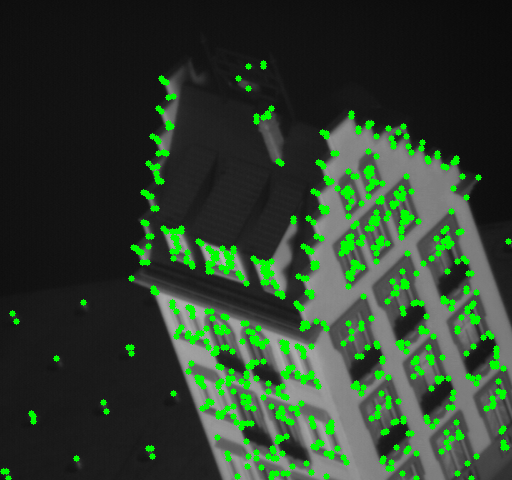

In [ ]:
def getKeypoints(img, tau):
    '''
    Detecting keypoints using Harris corner criterion
    img: input image
    tau: threshold 
    
    output: (N,2) array of [x,y] keypoints
    '''
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    R = np.zeros_like(img_gray)

    img_blur = cv2.GaussianBlur(img_gray, (3,3), 1)

    Ix, Iy = np.gradient(img_gray)

    Ixx = Ix**2
    Iyy = Iy**2
    Ixy =Ix*Iy

    h, w = img.shape[0], img.shape[1]
    window_size = 3
    offset = int( window_size / 2)
    
    # Computing Harris score for image
    for y in range(offset, h-offset):
        for x in range(offset, w-offset):
            A = np.sum(Ixx[y-offset:y+1+offset, x-offset:x+1+offset])
            B = np.sum(Ixy[y-offset:y+1+offset, x-offset:x+1+offset])
            C = np.sum(Iyy[y-offset:y+1+offset, x-offset:x+1+offset])

            H = np.array([[A,B], [B,C]])
            det = np.linalg.det(H)
            T = np.matrix.trace(H)

            R[y-offset, x-offset] = det/T   # Harris score
    cv2.normalize(R,R,0,1,cv2.NORM_MINMAX)
    
    # Non-maximum supression
    kpts = []
    for y in range(offset, h-offset, 5):
        for x in range(offset, w-offset, 5):
            window = R[y-offset:y+1+offset, x-offset:x+1+offset]
            _, maxVal, _, maxLoc = cv2.minMaxLoc(window)
            if maxVal > tau:
                kpts.append([x+maxLoc[0], y+maxLoc[1]])
    return np.array(kpts)

# compute keypoints in the first sequence
tau = 0.06
key_pts = getKeypoints(im[0], tau)
print(key_pts.shape[0],'corners detected.')

# plots for writeup
img_out = np.copy(im[0])
for x,y in key_pts:
    cv2.circle(img_out,(x, y), 3, (0,255,0), -1)
cv2_imshow(img_out)

### Write-up (10 pts)


*   (5 pts) Explain your implementation of getKeypoints()
*   (5 pts) Display the first frame of the sequence overlaid with the detected keypoints. Ensure that they are clearly visible (plot with `color='g' and linewidths=3`)



getKeypoints() function takes an image and threshold-tau as input parameters. The image is converted to grayscale, then blurred and its gradients in x and y directions are computed. A sliding window is taken over the image and using Harris Corner criterion Harris score is calculated for the each pixel of the image. Non-mamimum supression is implemented by taking maximum Harris score for 5x5 windows over the image and if the score is greater than the tau, location defined as a keypoint and returned as output.

## 1.2 Feature Tracking (35 pts)

Apply the Kanade-Lucas-Tomasi tracking procedure to track the keypoints found in part 1.1 (or the given keypoints in the *Data* section) throughout the hotel sequence. 

<img src="https://drive.google.com/uc?id=1dU4p4YcnXoQFnrNvleEty_4tDECkVW9Q" width="500"/>

Some keypoints will move out of the image frame over the course of the sequence. Discard any track if the predicted translation falls outside the image frame.

**Hint:**

*  From the 1st frame to the 2nd frame, use the detected keypoints at the first frame as initialization points. From the 2nd to 3rd frame, use the tracked positions at the 2nd frame as initialization. Note that the tracked keypoints in general are not at integer positions.

*  For each point, use a window size of 15 x 15.

Add codes to **plot** your tracked points overlayed in the **first sequence** and the **last sequence**. They should look similar to the second picture shown in the Overview section. 



### Code (10 pts)

Total Keypoints: 690


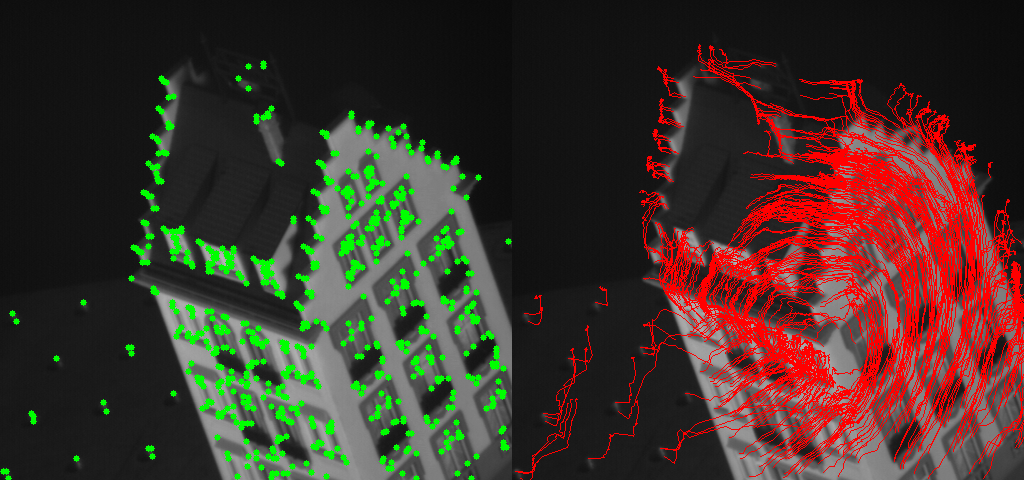


Path of 20 keypoints


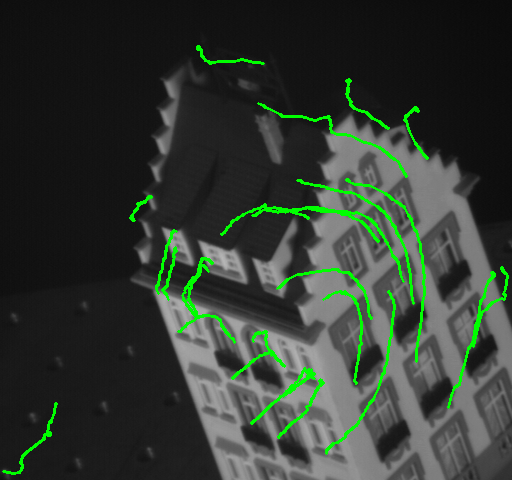


Keypoints moving out of frame.


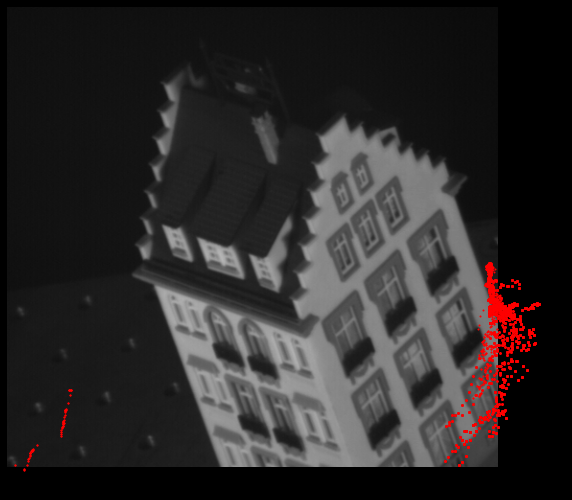

In [ ]:
def getNextPoints(x, y, im1, im2, ws):
    '''
    Iterative Lucas-Kanade feature tracking
    x,  y : initialized keypoint position in im2
    ws: patch window size

    output: tracked keypoint positions in im2
    '''
    global outliers
    hw = int(ws/2)
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    
    x2 = np.copy(x)
    y2 = np.copy(y)

    Iy, Ix = np.gradient(im1)

    for i in range(len(x)):
        Ix_w = cv2.getRectSubPix(Ix, (ws, ws), (x[i], y[i]))
        Iy_w = cv2.getRectSubPix(Iy, (ws, ws), (x[i], y[i]))

        Ixx = np.sum(Ix_w**2)
        Ixy = np.sum(Ix_w * Iy_w)
        Iyy = np.sum(Iy_w**2)

        It_w = cv2.getRectSubPix(
            im2, (ws, ws), (x2[i], y2[i])) - cv2.getRectSubPix(im1, (ws, ws), (x[i], y[i]))

        for iterations in range(5):
            Ixt = np.sum(Ix_w * It_w)
            Iyt = np.sum(Iy_w * It_w)

            A = np.array([[Ixx, Ixy], 
                          [Ixy, Iyy]])
            b = np.array([Ixt, Iyt])

            try:
                d = np.linalg.solve(A, b)
            except np.linalg.LinAlgError:
                pass

            x2[i] += d[0]
            y2[i] += d[1]

            if x2[i] > hw and x2[i] < im.shape[1]-hw and y2[i] > hw and y2[i] < im.shape[0]-hw:
                It_w = cv2.getRectSubPix(im2, (ws, ws), (x2[i], y2[i])) - cv2.getRectSubPix(im1, (ws, ws), (x[i], y[i]))
                break
            
    return x2, y2


ws = 15
# # Given keypoints
# X0 = np.array(X0)
# Y0 = np.array(Y0)
# key_pts = np.concatenate((X0,Y0),axis=1)

print('Total Keypoints:', key_pts[:,0].shape[0])
tracked_pts = trackPoints(pt_x=key_pts[:,0], pt_y=key_pts[:,1], im=im, ws=ws)

# Plots for writeup
img_out1 = np.copy(im[0])
for i in range(tracked_pts[:][0].shape[0]):
    for j in range(tracked_pts[:][0][0].shape[0]-1):
        start_point = (int(tracked_pts[:][0][i][j]), int(tracked_pts[:][1][i][j]))
        end_point = (int(tracked_pts[:][0][i][j+1]), int(tracked_pts[:][1][i][j+1]))
        cv2.line(img_out1, start_point, end_point, (0,0,255), 1)
img_out1 = np.concatenate((img_out,img_out1), axis=1)
cv2_imshow(img_out1)

# plot 20 keypoint tracks
img_out2 = np.copy(im[0])
print('\nPath of 20 keypoints')
for i in range(0,tracked_pts[:][0].shape[0], 27):   # 555/20 increment to plot around 20 kpts 
    for j in range(tracked_pts[:][0][0].shape[0]-1):
        start_point = (int(tracked_pts[:][0][i][j]), int(tracked_pts[:][1][i][j]))
        end_point = (int(tracked_pts[:][0][i][j+1]), int(tracked_pts[:][1][i][j+1]))
        cv2.line(img_out2, start_point, end_point, (0,255,0), 2)
cv2_imshow(img_out2)

# Plot outliers
print('\nKeypoints moving out of frame.')
outliers_x = np.where(tracked_pts[0] > im[0].shape[1])
outliers_y = np.where(tracked_pts[1] > im[0].shape[0])

plt.figure(figsize=(10, 10))
img_out3 = np.array(im[0], dtype=np.uint8)
plt.gcf().set_facecolor('black')
plt.axis('off')
plt.imshow(img_out3, cmap='gray')

for i in outliers_x[0]:
    plt.scatter(tracked_pts[0][i].ravel(), tracked_pts[1][i].ravel(), s=1, c='r')
for i in outliers_y[0]:
    plt.scatter(tracked_pts[0][i].ravel(), tracked_pts[1][i].ravel(), s=1, c='r')

### Write-up (25 pts)

*   (5 pts) For all the keypoints, display (1) the keypoints at the first frame (as green) and (2) the tracked keypoints at the second frame (as red) on the first frame of the sequence.
*   (10 pts) For 20 random keypoints, draw the 2D path over the sequence of frames. That is, plot the progression of image coordinates for each of the 20 keypoints. Plot each of the paths on the same figure, overlaid on the first frame of the sequence.
*   (10 pts) On top of the first frame, plot the points which have moved out of frame at some point along the sequence.





**Include your write-up here**

# Part 2: Shape Alignment (30 Points)

## Overview
In this problem, you will write a function that aligns two sets of points using global image transformation (similarity, affine, or perspective) and returns $T$  where $T$ is a transformation that maps non-zero points in $im1$ to non-zero points in $im2$. You may choose the alignment algorithm and the type of (global) transformation (e.g., rigid Euclidean, affine, perspective).


<img src="https://drive.google.com/uc?id=1PnWIy9ZdP9SGkmGNtFCJ-JzKLwmW-qaN" width="1000"/>

Test your code on the 25 image pairs provided in the supplementary material. We have included functions 
**(will check) evalAlignmentAll and displayAlignment to help with evaluation and display**.




## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
!unzip "/content/part2_images.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
To: /content/part2_images.zip
100% 78.4k/78.4k [00:00<00:00, 48.0MB/s]
Archive:  /content/part2_images.zip
   creating: /content/part2_images/
 extracting: /content/part2_images/Bone_1.png  
 extracting: /content/part2_images/elephant_1.png  
 extracting: /content/part2_images/brick_2.png  
 extracting: /content/part2_images/Heart_2.png  
 extracting: /content/part2_images/Bone_2.png  
  inflating: /content/part2_images/elephant_2.png  
 extracting: /content/part2_images/brick_1.png  
 extracting: /content/part2_images/Heart_1.png  
  inflating: /content/part2_images/device7_1.png  
  inflating: /content/part2_images/device7_2.png  
 extracting: /content/part2_images/fork_2.png  
 extracting: /content/part2_images/turtle_2.png  
  inflating: /content/part2_images/fork_1.png  
 extracting: /content/part2_images/turtle_1.png  
 extracting: /content/part2_images/butterfly_2.png  
 extracting: /content/pa

## Helper Functions

In [ ]:
def evalAlignment(aligned1, im2):
  '''
  Computes the error of the aligned image (aligned1) and im2, as the
  average of the average minimum distance of a point in aligned1 to a point in im2
  and the average minimum distance of a point in im2 to aligned1.
  '''
  d2 = ndimage.distance_transform_edt(1-im2) #distance transform
  err1 = np.mean(np.mean(d2[aligned1 > 0]))
  d1 = ndimage.distance_transform_edt(1-aligned1);
  err2 = np.mean(np.mean(d2[im2 > 0]))
  err = (err1+err2)/2;
  return err

def displayAlignment(im1, im2, aligned1, thick=False):
  '''
  Displays the alignment of im1 to im2
     im1: first input image to alignment algorithm (im1(y, x)=1 if (y, x) 
      is an original point in the first image)
     im2: second input image to alignment algorithm
     aligned1: new1(y, x) = 1 iff (y, x) is a rounded transformed point from the first time 
     thick: true if a line should be thickened for display
  ''' 
  if thick:
    # for thick lines (looks better for final display)
    dispim = np.concatenate((cv2.dilate(im1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(aligned1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(im2.astype('uint8'), np.ones((3,3), np.uint8), iterations=1)), axis=-1)
  else:
    # for thin lines (faster)
    dispim = np.concatenate((im1, aligned1, im2), axis = -1)
  return dispim
  
def initialize_T(x1, y1, x2, y2):
    mean_x1 = np.mean(x1)
    mean_y1 = np.mean(y1)
    mean_x2 = np.mean(x2)
    mean_y2 = np.mean(y2)

    var_x1 = np.var(x1)
    var_y1 = np.var(y1)
    var_x2 = np.var(x2)
    var_y2 = np.var(y2)

    t_x = mean_x1 - mean_x2
    t_y = mean_y1 - mean_y2

    s_x = var_x2 / var_x1
    s_y = var_y2 / var_y1

    T = np.array([[s_x, 0, t_x],
                  [0, s_y, t_y],
                  [0, 0, 1]])
    return T

def nearest_neighbor(A_hg, B_hg):
    distance_matrix = np.sum(
        (A_hg[:, None, :] - B_hg[None, :, :]) ** 2, axis=2) ** 0.5
    distance = np.min(distance_matrix, axis=1)
    index = np.argmin(distance_matrix, axis=1)

    return distance, index

def computeT(A, B):
    m = A.shape[1]

    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R, centroid_A.T)

    # homogeneous transformation matrix
    T = np.identity(m + 1)
    T[:m, :m] = R
    T[:m, m] = t

    return T

def icp(A, B, init_pose, max_iter, threshold=0.001):
    m = A.shape[1]

    # make points homogeneous
    A_hg = np.ones((m + 1, A.shape[0]))
    B_hg = np.ones((m + 1, B.shape[0]))
    A_hg[:m, :] = np.copy(A.T)
    B_hg[:m, :] = np.copy(B.T)

    # apply the initial pose
    A_hg = np.dot(init_pose, A_hg)

    init_error = 0
    for i in range(max_iter):
        distance, index = nearest_neighbor(A_hg[:m, :].T, B_hg[:m, :].T)

        T = computeT(A_hg[:m, :].T, B_hg[:m, index].T)

        A_hg = np.dot(T, A_hg)

        mean_error = np.mean(distance)
        if np.abs(init_error - mean_error) < threshold:
            break
        init_error = mean_error

    # final transformation
    T = computeT(A, A_hg[:m, :].T)

    return T, A_hg

## Code (15 pts)

1) apple
Final error: 190.82765391919844
Runtime: 0.33893322944641113


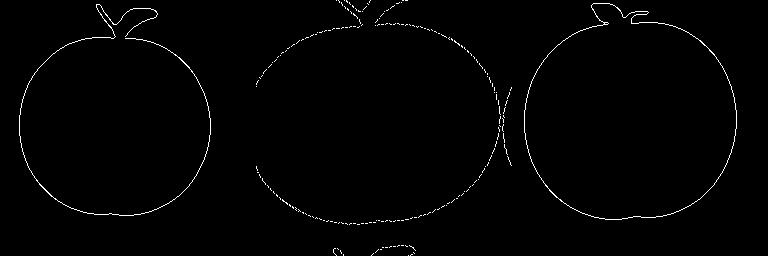



2) bat
Final error: 421.67078859615106
Runtime: 1.0224614143371582


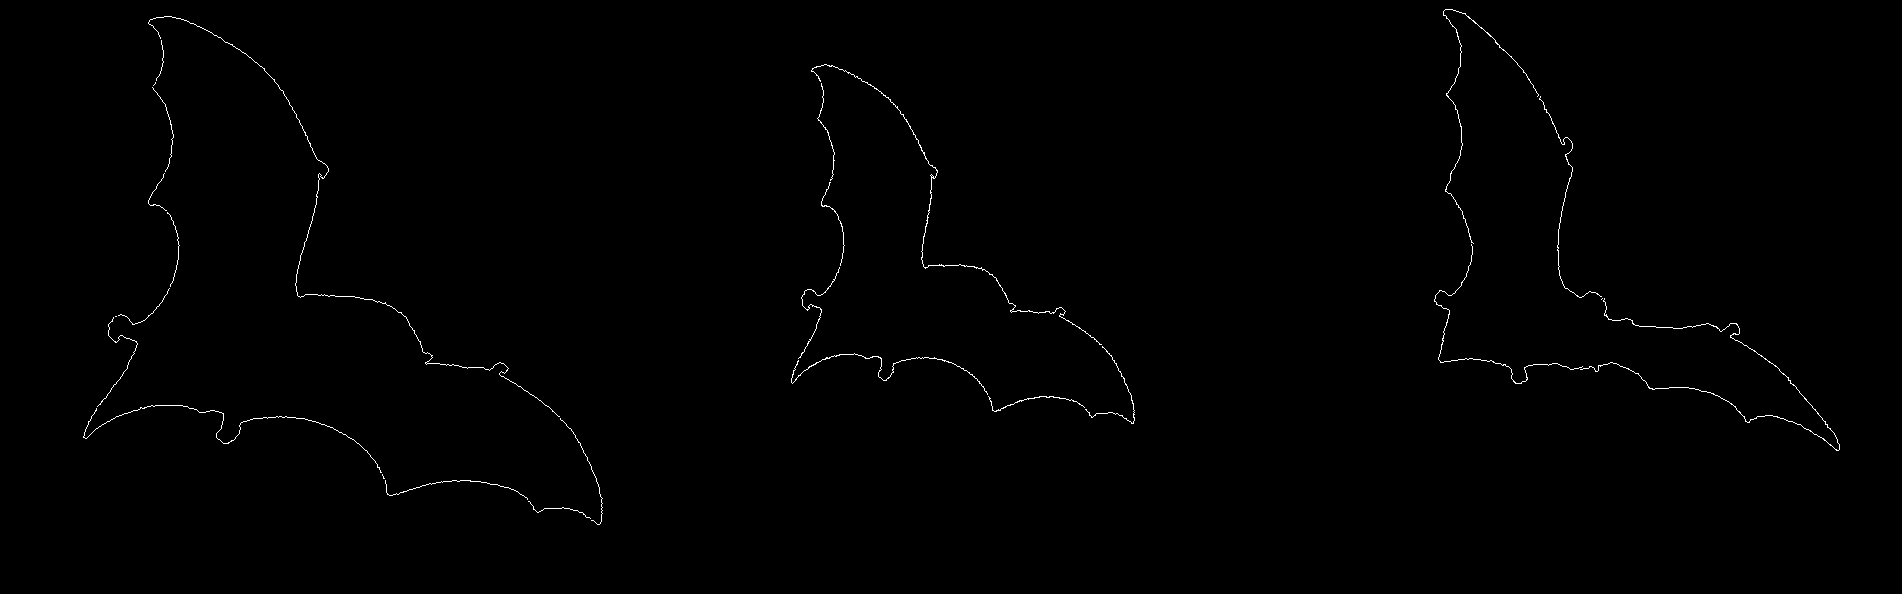



3) bell
Final error: 182.58781805730456
Runtime: 0.08105707168579102


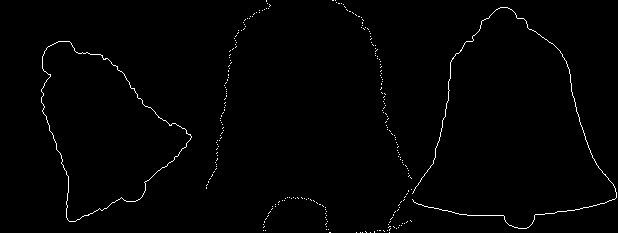



4) bird
Final error: 243.95929280469642
Runtime: 0.6409707069396973


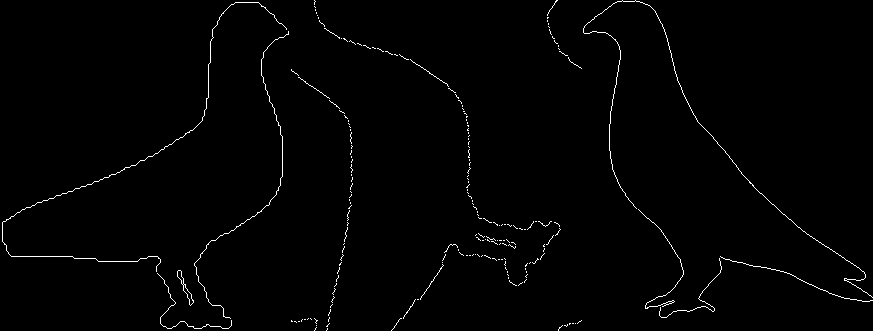



5) Bone
Final error: 321.06007576322037
Runtime: 0.21814966201782227


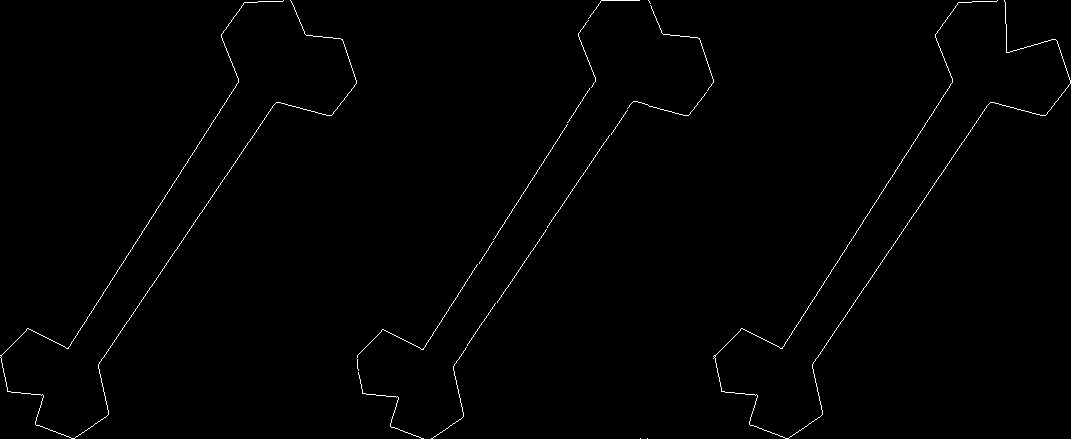



6) bottle
Final error: 246.49032493894165
Runtime: 0.04893898963928223


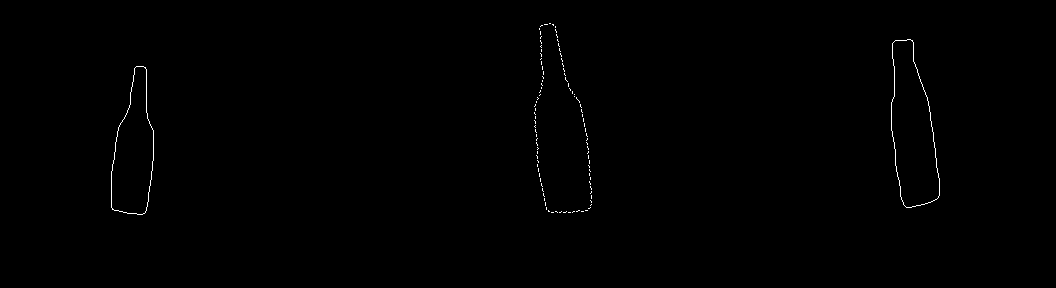



7) brick
Final error: 304.00298963030787
Runtime: 0.06046938896179199


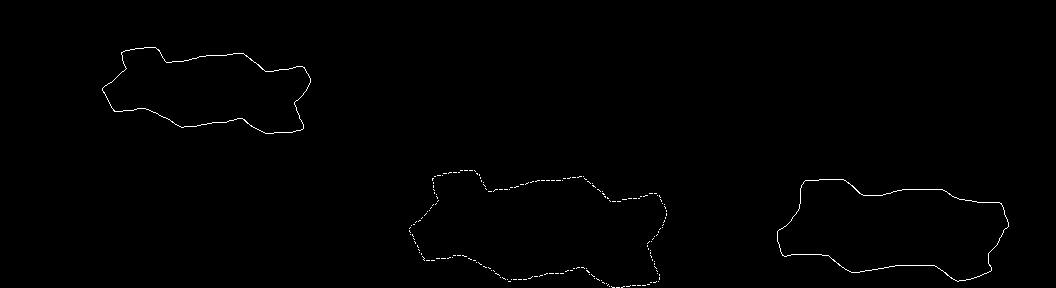



8) butterfly
Final error: 211.98429273299672
Runtime: 0.521765947341919


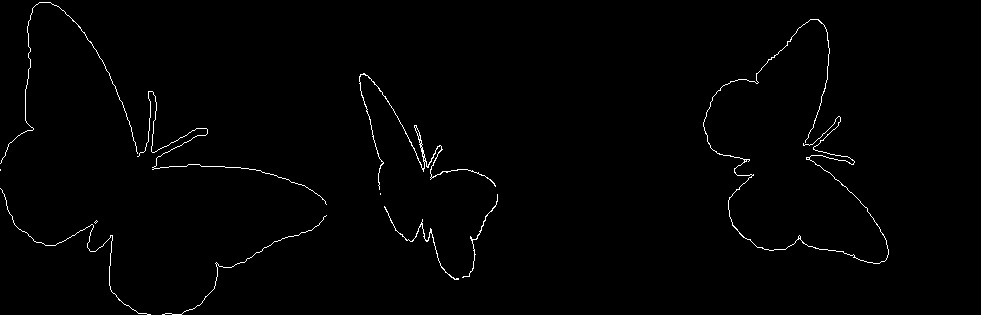



9) camel
Final error: 274.2124469889842
Runtime: 1.2519927024841309


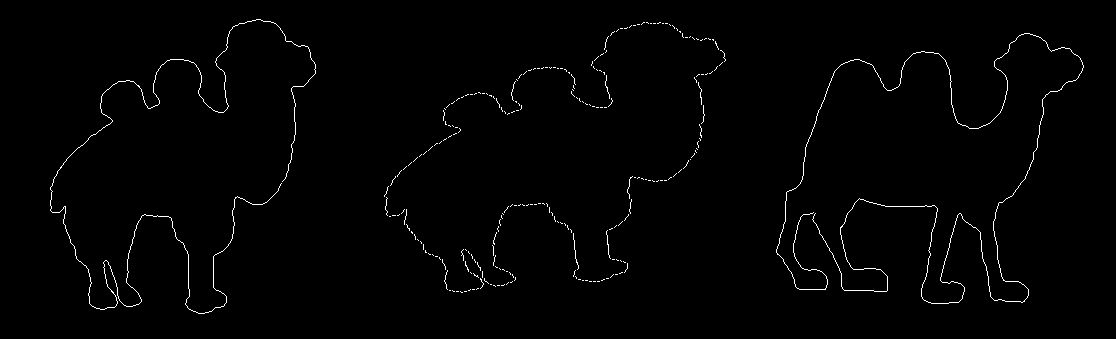



10) car
Final error: 243.0947600575169
Runtime: 0.05239272117614746


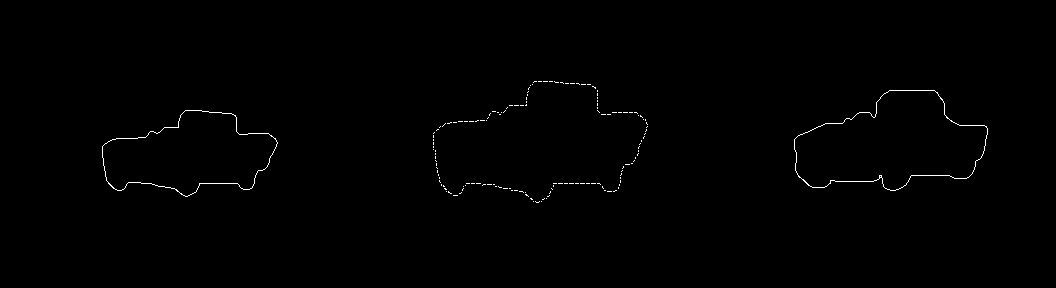



11) carriage
Final error: 283.958646816356
Runtime: 0.3015894889831543


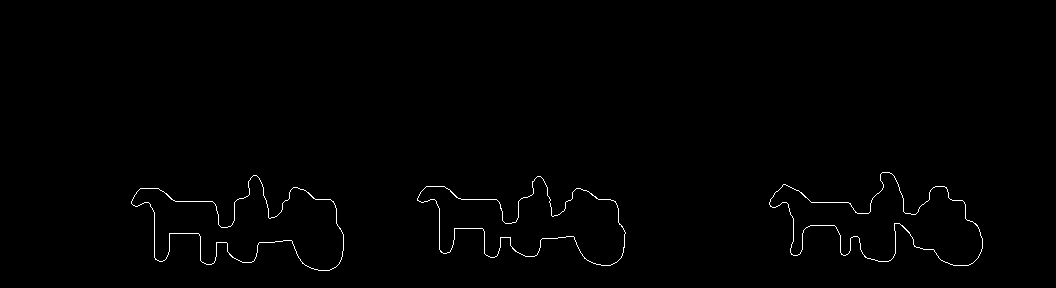



12) cattle
Final error: 369.66766243471193
Runtime: 3.858365297317505


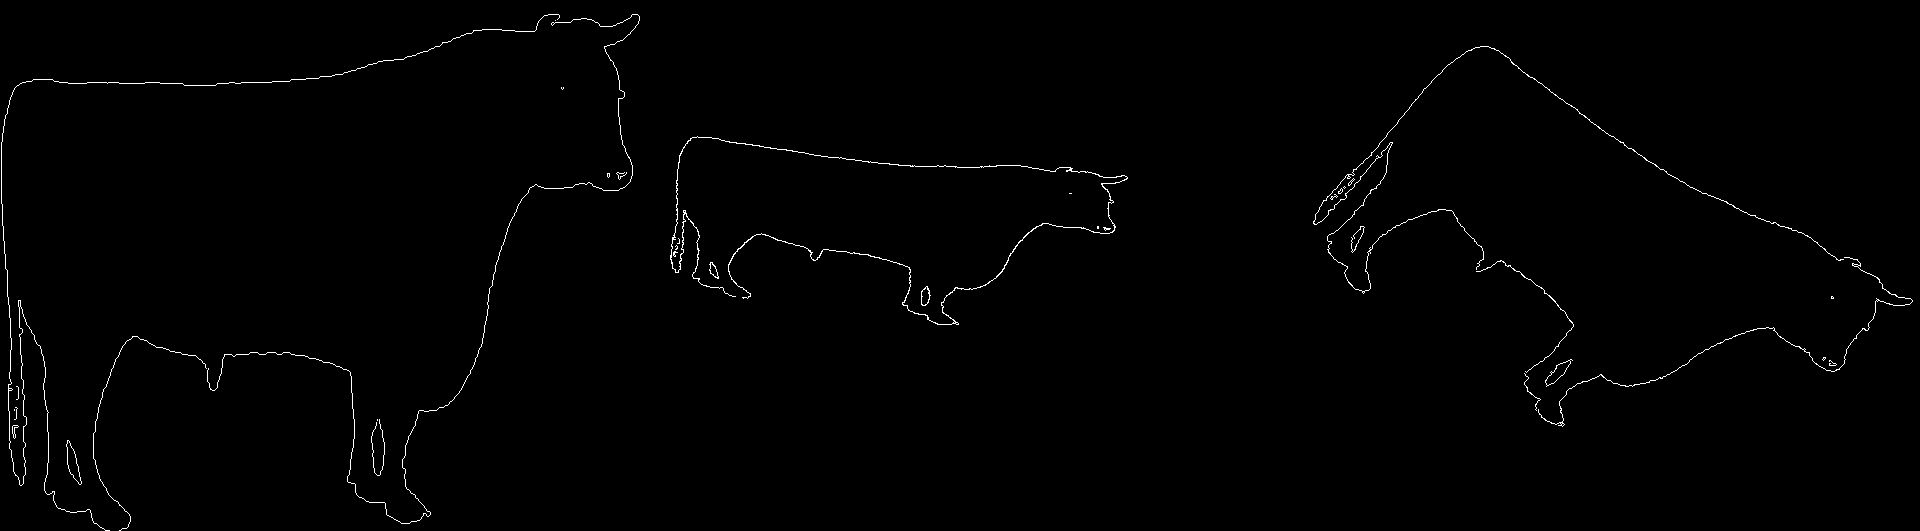



13) cellular_phone
Final error: 261.9945144530477
Runtime: 0.16207194328308105


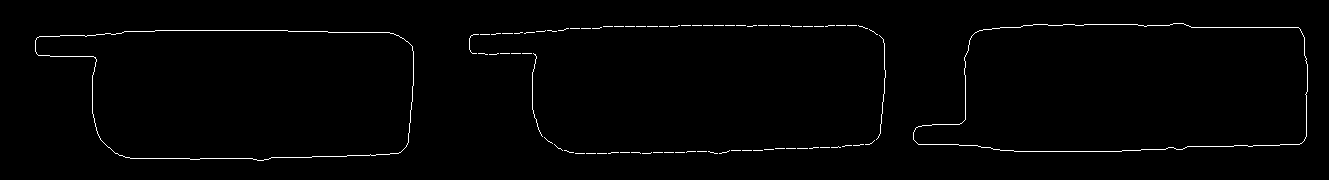



14) chicken
Final error: 153.84440433416114
Runtime: 0.15815401077270508


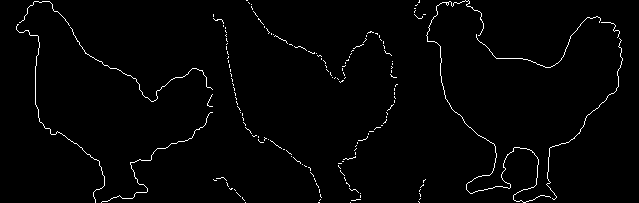



15) children
Final error: 156.34019593044252
Runtime: 0.018146991729736328


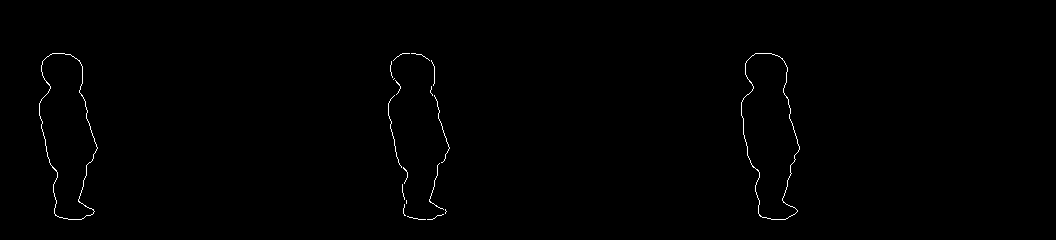



16) device7
Final error: 383.38082174711843
Runtime: 1.6618449687957764


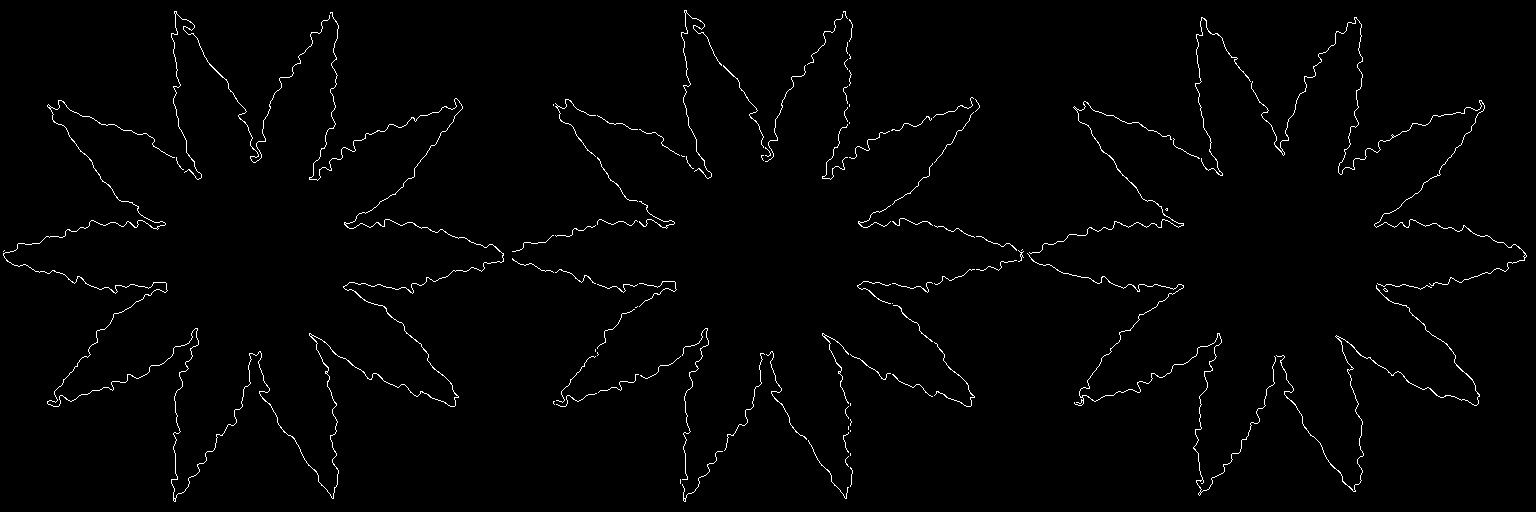



17) dog
Final error: 357.240285212594
Runtime: 1.8526496887207031


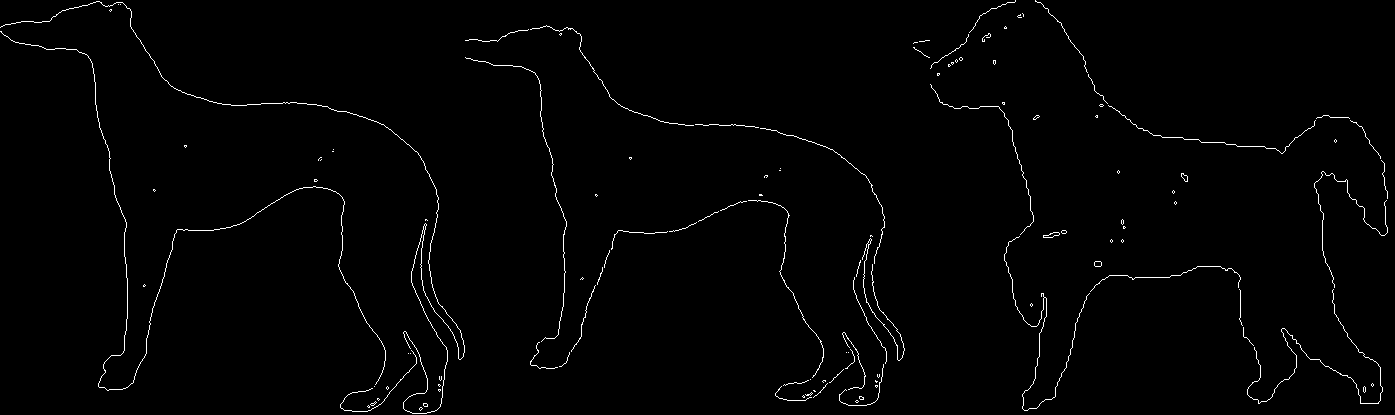



18) elephant
Final error: 566.157192395939
Runtime: 2.4443295001983643


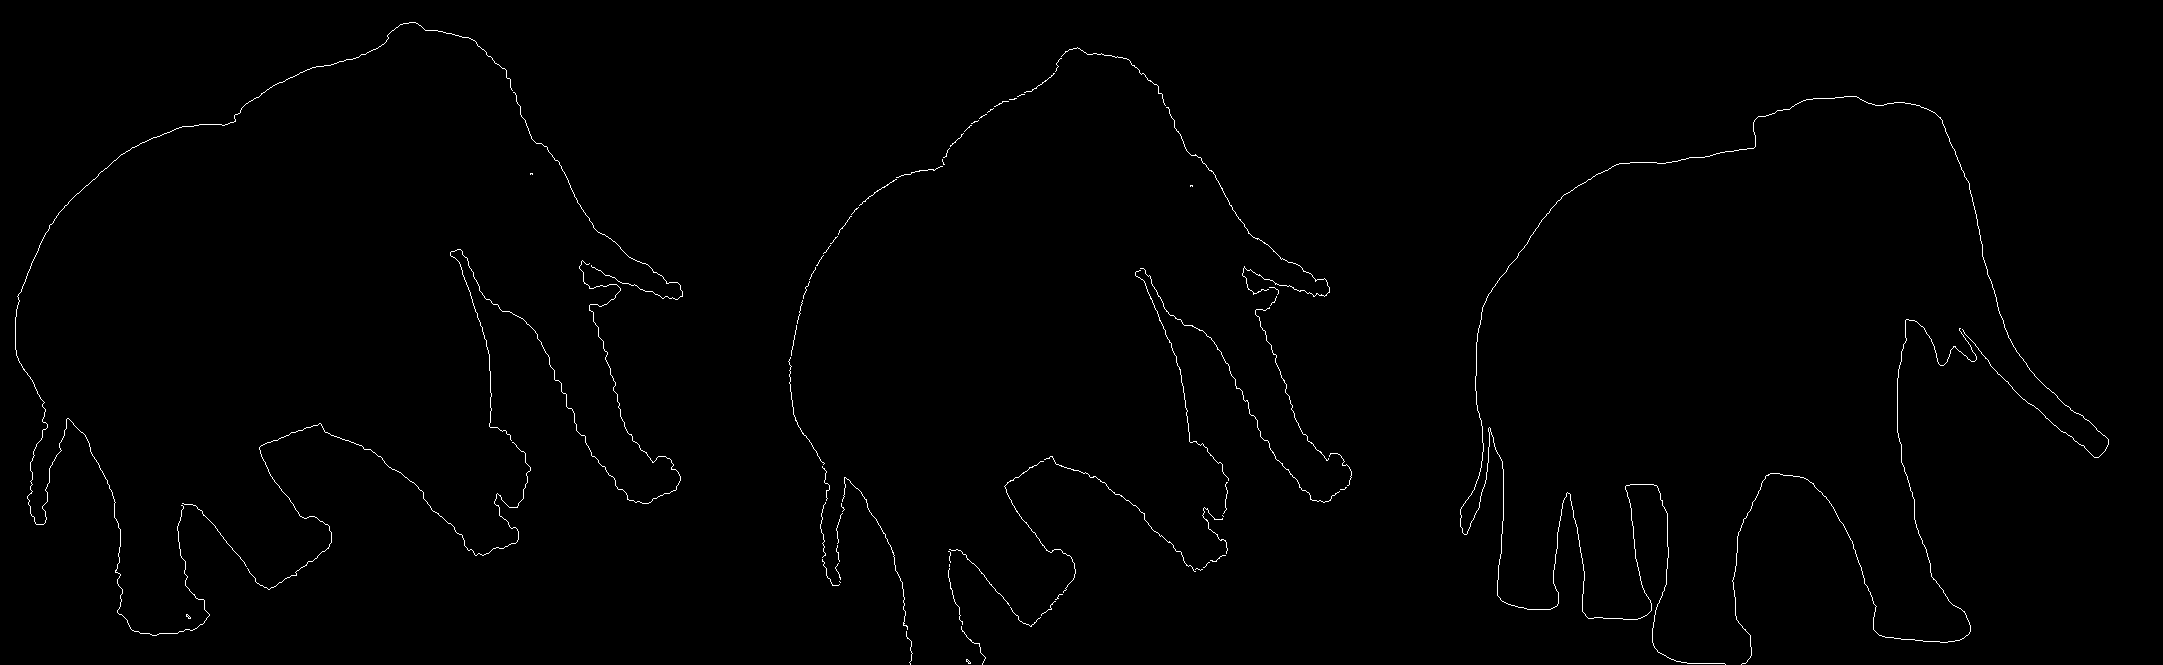



19) face
Final error: 232.94447127490747
Runtime: 0.11273312568664551


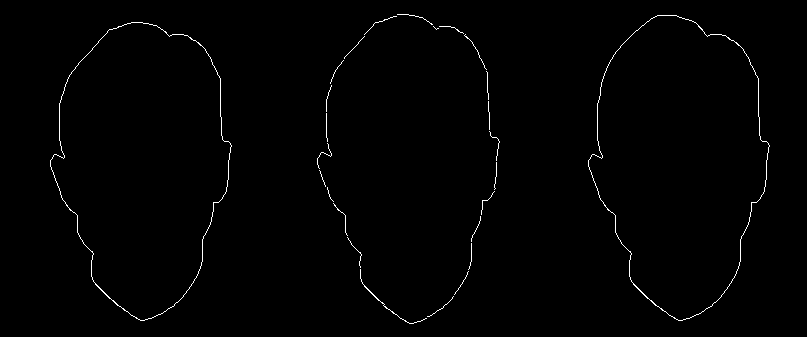



20) fork
Final error: 357.94298518285814
Runtime: 1.857792854309082


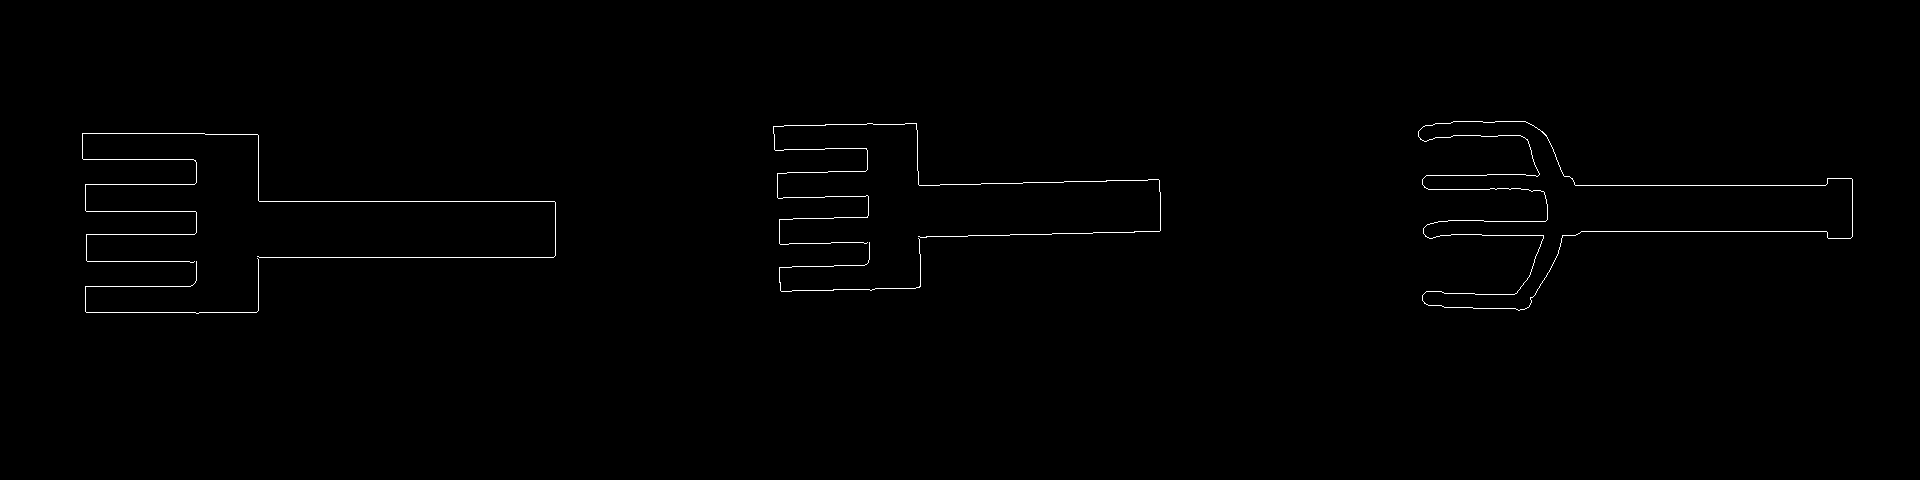



21) hammer
Final error: 162.6946379802944
Runtime: 0.13309693336486816


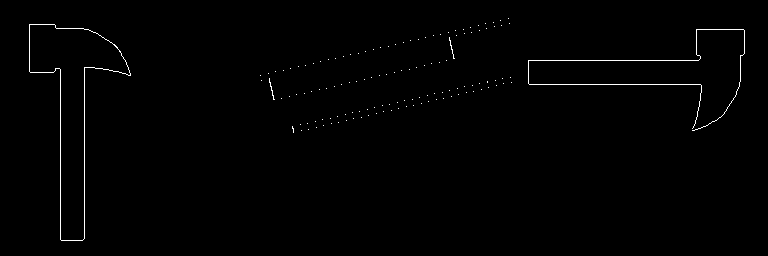



22) Heart
Final error: 328.2514868488008
Runtime: 0.22170782089233398


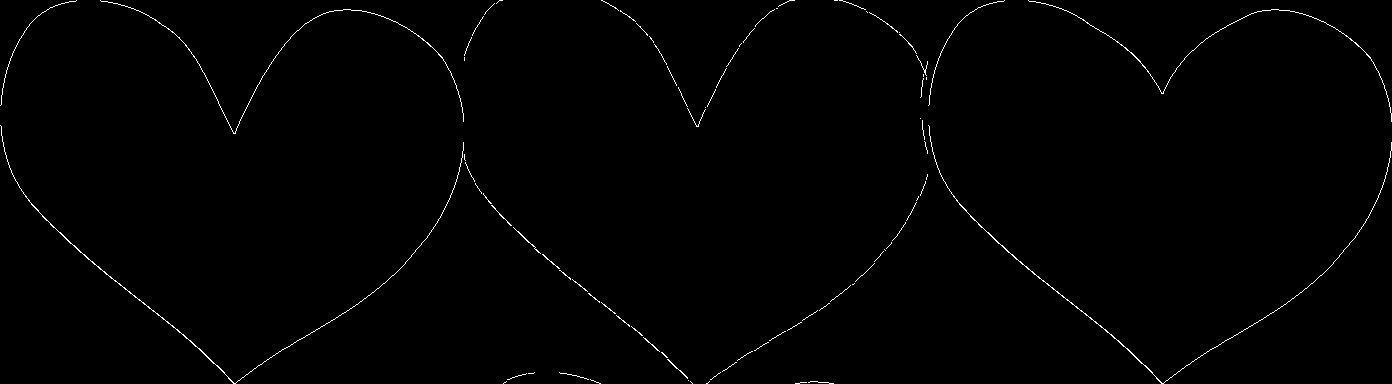



23) horse
Final error: 495.2274124547896
Runtime: 4.165269136428833


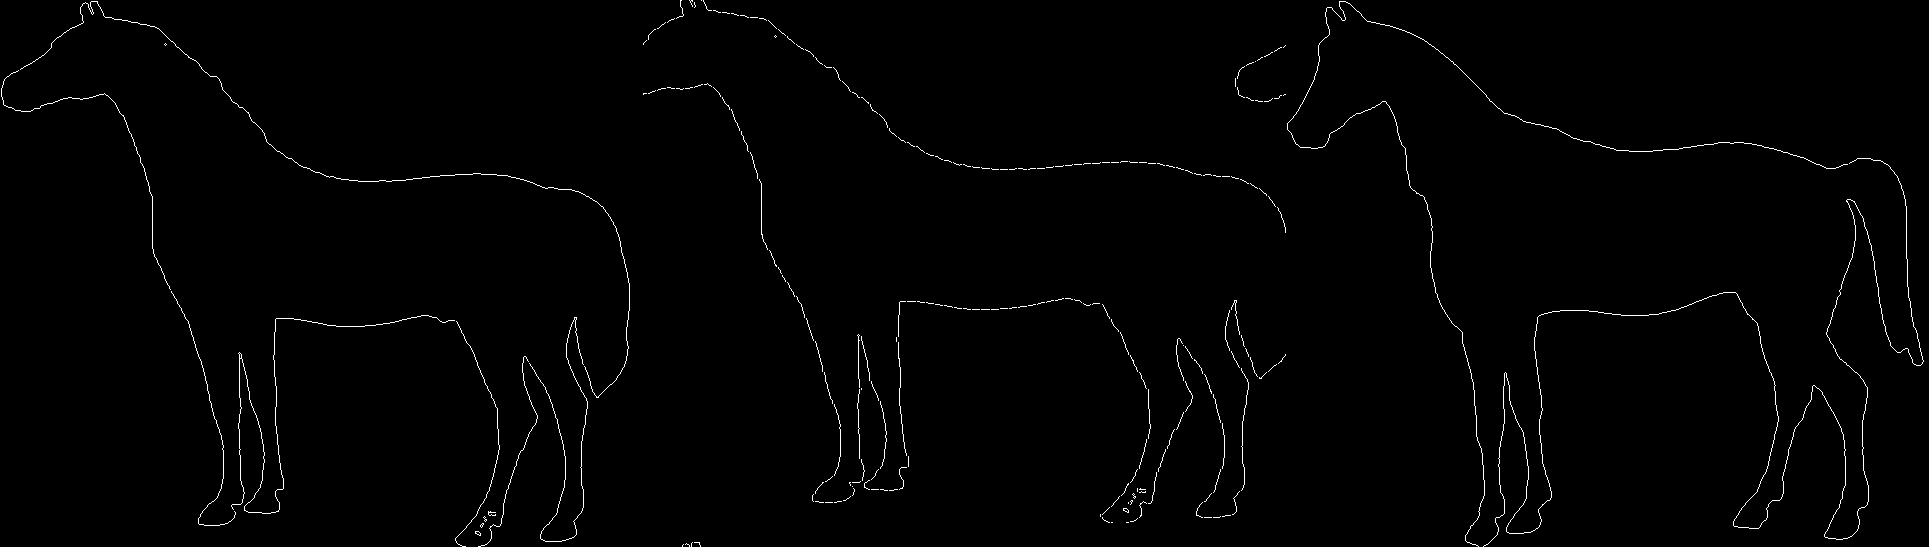



24) jar
Final error: 384.8549059216101
Runtime: 0.75514817237854


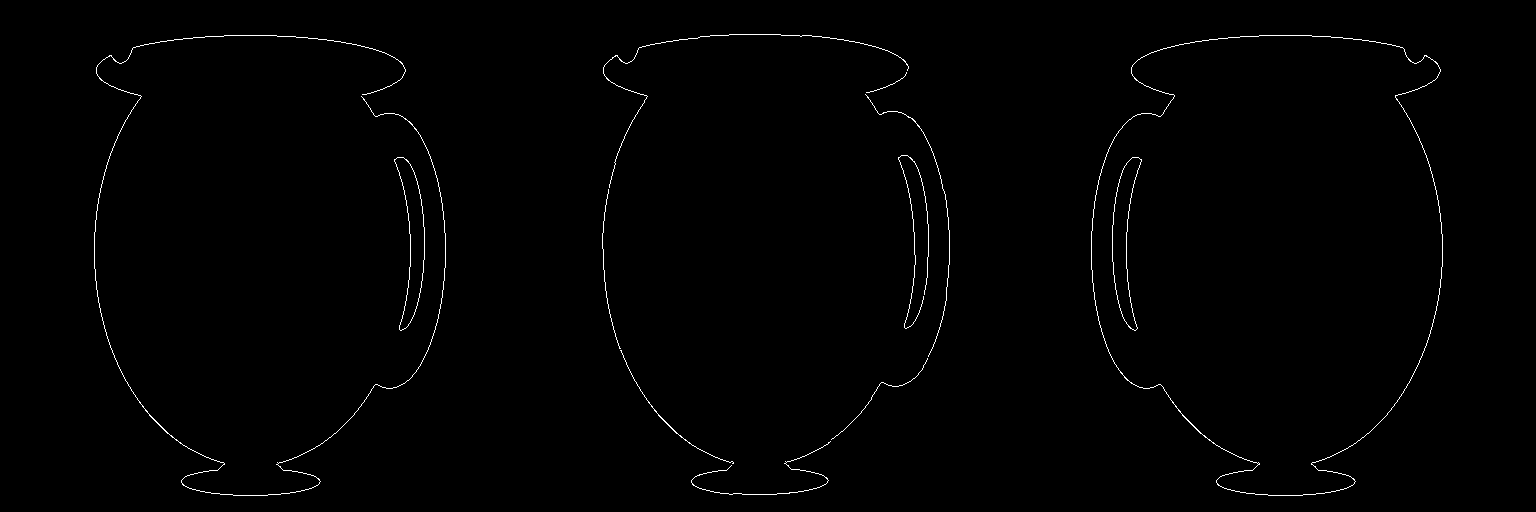



25) turtle
Final error: 253.2221154232233
Runtime: 0.3141026496887207


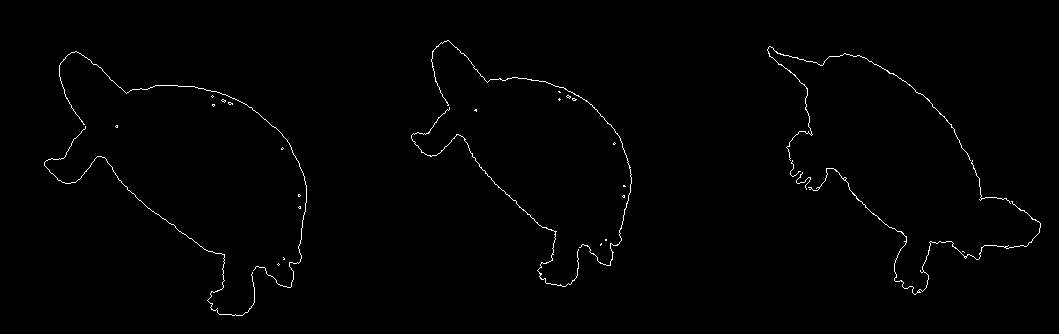

In [ ]:
imgPath = '/content/part2_images/'

objList = ['apple', 'bat', 'bell', 'bird', 'Bone', 'bottle', 'brick',
           'butterfly', 'camel', 'car', 'carriage', 'cattle', 'cellular_phone',
           'chicken', 'children', 'device7', 'dog', 'elephant', 'face', 'fork',
           'hammer', 'Heart', 'horse', 'jar', 'turtle']

for i in range(len(objList)):
    print(str(i + 1) + ') ' + objList[i])
    im1 = cv2.imread('/content/part2_images/' + objList[i] + '_1.png', 0)
    im2 = cv2.imread('/content/part2_images/' + objList[i] + '_2.png', 0)

    x1, y1 = np.where(im1 == 255)
    x2, y2 = np.where(im2 == 255)
    initial_T = initialize_T(x1, y1, x2, y2)

    A = np.array([x1, y1]).T
    B = np.array([x2, y2]).T

    t1 = time.time()
    T, src_new = icp(A, B, initial_T, 50, 0.001)
    runtime = time.time() - t1

    img_aligned = np.zeros_like(im1)
    for i in range(src_new.shape[1]):
        x = int(src_new[:, i][0])
        y = int(src_new[:, i][1])
        try:
            img_aligned[x, y] = 255
        except IndexError:
            pass

    error = evalAlignment(img_aligned, im2)
    print('Final error:', error)
    print('Runtime:', runtime)
    img_final = displayAlignment(im1, im2, img_aligned, thick=False)
    cv2_imshow(img_final)
    print('\n')

## Write-up (15 pt)

1. (5 pts) Give a brief explanation of your algorithm, initialization, and model of the transformation.

2. (10 pts) For each result, give:
  1.   The alignment display
  2.   The final error
  3.   The runtime






**Algorithm**
1. Start with finding edge points in both images.
2. Compute initial transformation matrix by finding centroids and scaling factors using variance.
3. Transform edge points of image 1 using initial transformation matrix.
4. Apply iterative closest point algorithm:
    - To get matches between egde points of image 1 and image 2, find nearest neighbour distance and thier corresponding indices.
    - Compute transformation matrices for edge points of image 1 and their nearest neighbour matches in edge points of image 2.
    - Use the computed transformation matrix to transform edge points of image 1.
    - Compute difference in mean nearest neighbour distances between iterations and check if it falls below threshold value.
5. Compute the final transformation matrix.
6. Use helper function to compute the alignment error.

# Part 3: Object Instance Recognition (20 points)

## Overview
This problem explores the Lowe-style object instance recognition.

Implement the nearest neighbor distance ratio test using the pre-computed SIFT features SIFT_features.mat provided in the supplementary material. The Frame1, Frame2 indicate the 2D position, scales, and the orientation of the descriptors and Descriptor1, Descriptor2 are the correspondin 128-D SIFT features. Display the matches like this:

<img src="https://drive.google.com/uc?id=1mULTvHYeP5uj_vi7nwWThBHkDbv1eSue" width="1000"/>



## Data

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 10ByzpFbB-z178VGjwmCwc95wInD8vpNM # SIFT Features
!gdown 1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU # Stop sign image 1
!gdown 13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J # Stop sign image 1

Downloading...
From: https://drive.google.com/uc?id=10ByzpFbB-z178VGjwmCwc95wInD8vpNM
To: /content/SIFT_features.mat
100% 347k/347k [00:00<00:00, 69.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU
To: /content/stop1.jpg
100% 15.6k/15.6k [00:00<00:00, 13.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J
To: /content/stop2.jpg
100% 224k/224k [00:00<00:00, 83.3MB/s]


## Code (10 pts)

32 matches found by thresholding nearest neighbour distances.


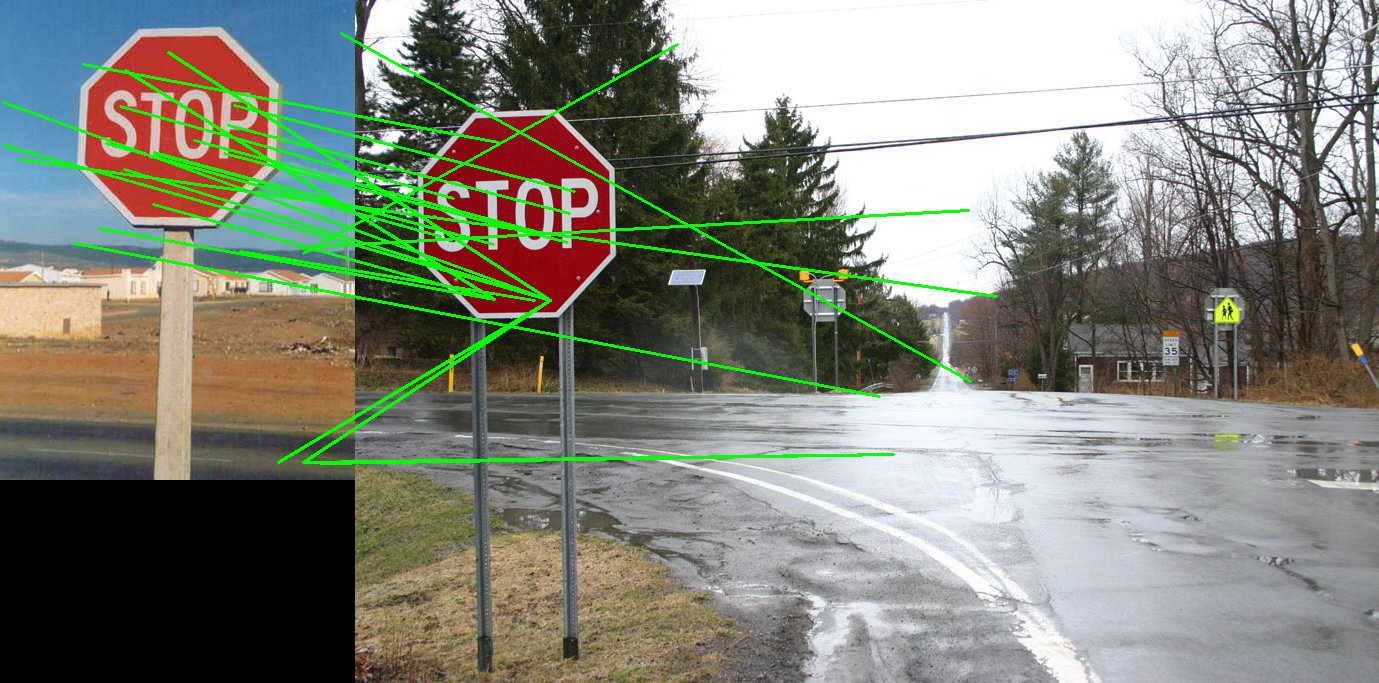


 33 matches found by thresholding distance ratio.


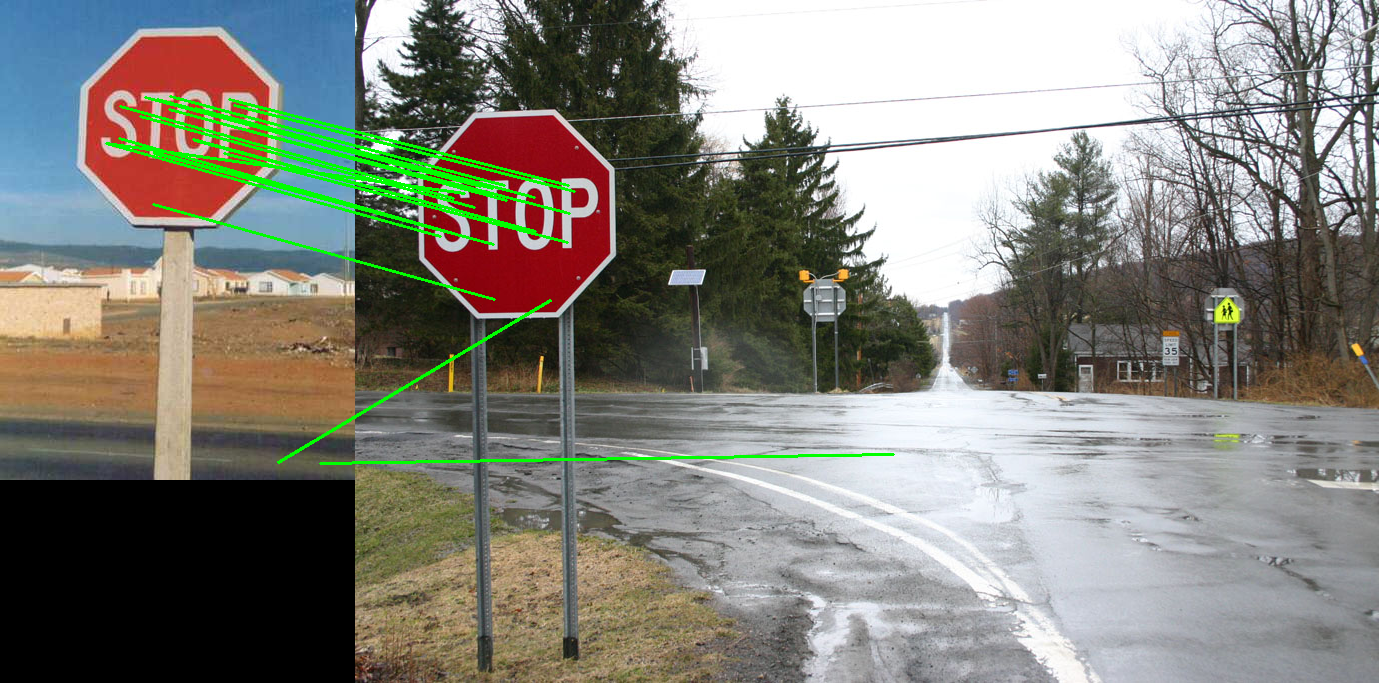

In [ ]:
img1 = cv2.imread('/content/stop1.jpg')
img2 = cv2.imread('/content/stop2.jpg')

## inside the sift are:
## Descriptor1, Descriptor2: SIFT features from image 1 and image 2
## Frame1, Frame2: position, scale, rotation of keypoints
data = loadmat('/content/SIFT_features.mat')
Frame1 = data['Frame1']
Descriptor1 = data['Descriptor1']
Frame2 = data['Frame2']
Descriptor2 = data['Descriptor2']

nn = [] # list of matches by thresholding nearest neighbour distances
dr = [] # list of matches by thresholding distance ratio

for i in range(Descriptor1.shape[1]):
    
    ssd = []
    for j in range(Descriptor2.shape[1]):
        ssd.append(np.sum((Descriptor1[:,i]-Descriptor2[:,j])**2))
    
    min1 = np.min(ssd)
    min1_idx = np.argmin(ssd)   # 1st nearest neighbour
    max = np.max(ssd)
    ssd[min1_idx] = max

    min2 = np.min(ssd)
    min2_idx = np.argmin(ssd)   # 2nd nearest neighbour

    dist_ratio = min1/min2

    # thresholding nearest neighbour distance
    if min1 < 3800:
        nn.append([i, min1_idx])

    # thresholding distance ratio
    if dist_ratio < 0.8:
        dr.append([i,min1_idx])

## Display the matched keypoints
img_out = np.zeros((img2.shape[0], img1.shape[1]+img2.shape[1],3), dtype=np.float32)
img_out[0:480,0:355] = img1
img_out[:,355:1379] = img2
img_out2 = img_out.copy()

print(len(nn),'matches found by thresholding nearest neighbour distances.')
for i in range(len(nn)):
    cv2.line(img_out, (int(Frame1[0,nn[i][0]]), int(Frame1[1,nn[i][0]])), (int(Frame2[0,nn[i][1]])+355, int(Frame2[1,nn[i][1]])), (0,255,0), 2)
cv2_imshow(img_out)

print('\n',len(dr),'matches found by thresholding distance ratio.')
for i in range(len(dr)):
    cv2.line(img_out2, (int(Frame1[0,dr[i][0]]), int(Frame1[1,dr[i][0]])), (int(Frame2[0,dr[i][1]])+355, int(Frame2[1,dr[i][1]])), (0,255,0), 2)
cv2_imshow(img_out2)

## Write-up (10 pts)

(5 pts) Display:

1. the matches by thresholding nearest neighbor distances.

2. the matches by thresholding the distance ratio. 

(5 pts) Describe the differences of (1) and (2).

First output image shows matches computed by thresholding nearest neighbor distances method, where for each SIFT descriptor of image 1 the SSD of all descriptors in image 2 is calculated. 
Second output image shows matches determined by thresholding the distance ratio of the 1st and 2nd nearest neighbours.

The major drawback of nearest neighbor distances method is that the user-defined threshold can provide inaccurate matches since, a good matches having larger SSD than the threshold will always be rejected.On the other hand, the distance ratio method ensures that the distance between 1st nearest and 2nd nearest neighbour is large helping reject false matches.